# Création de variable pour améliorer le modèle

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [2]:
train = pd.read_json("/Users/romainbrule/Documents/Cours/Master2/KAGGLE/stanford-covid-vaccine/train.json",lines=True)
train.set_index('index',inplace=True)

In [3]:
def expend_feature (df):
    """
    Return a dataframe with expension of sequence
    
    Args:
        df (Dataframe): same format as train
        i_row (int): number of row we want to expand
    
    Returns:
        sub_df: a dataframe with:
        number of rows = seq_scored
        columns name:[id, base, base_structure_type, base_predicted_loop_type, reactivity_error,
        deg_error_Mg_pH10,deg_error_pH10, deg_error_Mg_50C, deg_error_50C, reactivity, 
        deg_Mg_pH10, deg_pH10, deg_Mg_50C, deg_50C]
    """
    if (df.shape[0] != df.id.nunique()):
        print('repetition in RNA sequnence, clean dataframe first')
        return # dose the same as retunr None, which exit the function 
    
    else:
        col_names = ['id','base', 'base_structure_type', 'base_predicted_loop_type', 'reactivity_error',
            'deg_error_Mg_pH10', 'deg_error_pH10', 'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 
            'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

        #dataframe creation using list of lists
        # loop for each unique sequence
        sub_data = []
        for row_i in df.index:
            #loop for the legth of sequnece score (trian length is different from test)
            serie_i = df.loc[row_i] #panda series object
            seq_length  = serie_i['seq_scored']
            for seq_i in range (seq_length):
                seq_data = [serie_i['id'], serie_i['sequence'][seq_i],
                            serie_i['structure'][seq_i], serie_i['predicted_loop_type'][seq_i],
                            serie_i['reactivity_error'][seq_i], serie_i['deg_error_Mg_pH10'][seq_i],
                            serie_i['deg_error_pH10'][seq_i], serie_i['deg_error_Mg_50C'][seq_i],
                            serie_i['deg_error_50C'][seq_i], serie_i['reactivity'][seq_i],
                            serie_i['deg_Mg_pH10'][seq_i], serie_i['deg_pH10'][seq_i],
                            serie_i['deg_Mg_50C'][seq_i], serie_i['deg_50C'][seq_i]]
                sub_data.append(seq_data)

        sub_df = pd.DataFrame(sub_data, columns =col_names,  dtype = float) 
        return sub_df


def count(x,colonne):
    return (colonne==x).sum()


def add_features(seq): # Coumpt the numerous of the group
    # Concerning nucleotides
    gr_base=1
    seq['count_gr_base']=gr_base
    for i in range (1,seq.shape[0]):
        if ((seq.id.iloc[i]!=seq.id.iloc[i-1]) or (seq.base.iloc[i]!=seq.base.iloc[i-1])):
            gr_base=gr_base+1
        seq.count_gr_base[i]=gr_base
    #Count the number of nucleotide which are the same 
    seq['N_base']=seq['count_gr_base'].apply(lambda x: count(x,seq['count_gr_base']))
    
    # Concerning loop_type
    gr_loop_type=1
    seq['count_gr_loop_type']=gr_loop_type
    for i in range (1,seq.shape[0]):
        if ((seq.id.iloc[i]!=seq.id.iloc[i-1]) or (seq.base_predicted_loop_type.iloc[i]!=seq.base_predicted_loop_type.iloc[i-1])):
            gr_loop_type=gr_loop_type+1
        seq.count_gr_loop_type[i]=gr_loop_type
    #Count the number of letters in the group 
    seq['N_loop_type']=seq['count_gr_loop_type'].apply(lambda x: count(x,seq['count_gr_loop_type']))

    #Concerning the number of point in 'base_structure_type'
    Number_point=seq[seq.base_structure_type=='.'].groupby(["id"])['base_structure_type'].count()
    seq['N_point']=Number_point[0]
    idx=0
    for i in range (1,seq.shape[0]):
        if (seq.id.iloc[i]!=seq.id.iloc[i-1]):
            idx+=1
        seq.loc[i,['N_point']]=Number_point[idx]  
    
    return seq
    
    
def fianle_transform (dataframe):
    # filter with SN_filter criteria 
    data_filter = dataframe[dataframe["SN_filter"] == 1]
    
    #use expend to change feature 
    data_filter_seq = expend_feature(data_filter)
    
    #add feature 
    data_filter_seq = add_features(data_filter_seq)
    
    #make feature onehot encoding
    one_hot_base = pd.get_dummies(data_filter_seq['base'],drop_first=True) #drop "A"
    one_hot_loop = pd.get_dummies(data_filter_seq['base_predicted_loop_type'],drop_first=True) # drop "B"
    one_hot_struct = pd.get_dummies(data_filter_seq['base_structure_type'],drop_first=True)# drop "("
    
    #final dataset
    data_filter_seq = data_filter_seq.drop(["base", "base_predicted_loop_type","base_structure_type"], axis = 1)
    df = pd.concat([data_filter_seq,one_hot_base, one_hot_loop ,one_hot_struct], axis = 1)
    return df

In [4]:
seq=fianle_transform(train)
#seq = pd.read_csv("/Users/romainbrule/Documents/Cours/Master2/KAGGLE/train_model.csv")

/Users/romainbrule/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/romainbrule/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
#seq = pd.read_csv('seq_filter.csv').drop(columns = ['Unnamed: 0'])
seq.columns

Index(['id', 'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C', 'count_gr_base', 'N_base',
       'count_gr_loop_type', 'N_loop_type', 'N_point', 'C', 'G', 'U', 'E', 'H',
       'I', 'M', 'S', 'X', ')', '.'],
      dtype='object')

### Erreur de Kaggle

D'après Kaggle, le score est calculé par un MCRMSE. On créer donc une fonction qui le calcul:

In [6]:
#Notre erreur 

def MSE(vec1,vec2):
    Res = 0 
    n=len(vec1)
    for i in range (0,n):  #looping through each element of the list
        diff_squared = (vec1[i]-vec2[i])**2   
        Res = Res + diff_squared  #taking a sum of all the differences
    return Res/n #dividing summation by total values to obtain average

def MCRMSE(y_true, y_pred):
    y_true=y_true.values
    n,Nt=y_pred.shape
    Res=0
    for i in range(0,Nt):
        Res=Res+np.sqrt(MSE(y_true[:,i],y_pred[:,i]))
    return Res/Nt
    

### Modèle avec toute les features de base

In [7]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,['reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
          'deg_error_Mg_50C', 'deg_error_50C', 'C', 'G', 'U','E', 'H', 'I', 'M', 'S', 'X', ')', '.']]

In [8]:
 X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [9]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.3686208894502586


Néanmoins on utilise des features que l'on ne pourra pas utiliser

### Modèle linéaire de base

In [10]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,['C', 'G', 'U','E', 'H', 'I', 'M', 'S', 'X', ')', '.']]

In [11]:
 X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [12]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.43594757017695496


# Sur predicted_loop_type

### proportion de predicted_loop_type

In [13]:
seq['prop_E']=seq.E.sum()/len(seq)
seq['prop_H']=seq.H.sum()/len(seq)
seq['prop_I']=seq.I.sum()/len(seq)
seq['prop_M']=seq.M.sum()/len(seq)
seq['prop_S']=seq.S.sum()/len(seq)
seq['prop_X']=seq.X.sum()/len(seq)

In [14]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,['C', 'G', 'U','E', 'H', 'I', 'M', 'S', 'X', ')', '.','prop_E','prop_H','prop_I','prop_M',
             'prop_S','prop_X']]

In [15]:
 X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [16]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.43594320644040874


### ajout de longeur sequence loop_type

In [17]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,['N_loop_type', 'C', 'G', 'U','E', 'H', 'I', 'M', 'S', 'X', ')', '.']]

In [18]:
 X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [19]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.4153390601852943


L'ajout de la longeur de la chaine semble améliorer le modèle.

### ajout la longeur de la séquence par lettre loop_type

In [20]:
letters_loop_type_1=['E','H','I','M','S','X']

def ajout_N_predicted_loop(data):
    for i in letters_loop_type_1:
        col = np.where(data[i]==1, data['N_loop_type'], 0) 
        data ["N_"+i] = col
    col_B=np.where(data.N_E+data.N_H+data.N_I+data.N_M+data.N_S+data.N_X==0,data.N_loop_type,0)
    data["N_B"]=col_B
    return data

In [21]:
seq=ajout_N_predicted_loop(seq)

In [22]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,[ 'C', 'G', 'U','E', 'H', 'I', 'M', 'S', 'X', ')', 
             '.', 'N_E', 'N_H', 'N_I', 'N_M','N_S', 'N_X', 'N_B']]

In [23]:
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [24]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.4129670426456875


Améliore également un peu le modèle

### que la longeur de la séquence par lettre loop_type

In [25]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,[ 'C', 'G', 'U', ')','.', 'N_E', 'N_H', 'N_I', 'N_M','N_S', 'N_X', 'N_B']]

In [26]:
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [27]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.43959432599836534


Modèle moins bon

# Sur nucléotides

### ajout de la proportion des nucléotides

In [28]:
seq['prop_C']=seq.C.sum()/len(seq)
seq['prop_G']=seq.G.sum()/len(seq)
seq['prop_U']=seq.U.sum()/len(seq)

In [29]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,['C', 'G', 'U','E', 'H', 'I', 'M', 'S', 'X', ')', '.','prop_C','prop_G','prop_U']]

In [30]:
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [31]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.4359232751205944


Le modèle ne change quasiment pas 

### ajout de la longeur de la séquence des nucléotides 

In [32]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,['N_base', 'C', 'G', 'U','E', 'H', 'I', 'M', 'S', 'X', ')', '.']]

In [33]:
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [34]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.4357248281682562


Améliore très legerement le modèle de base

### ajout la longeur de la séquence des nucléotides

In [35]:
letters_nucleotide_1=['C','G','U']

def ajout_N_nucleotide(data):
    for i in letters_nucleotide_1:
        col = np.where(data[i]==1, data['N_base'], 0) 
        data ["N_base_"+i] = col
    col_A=np.where(data.N_base_C+data.N_base_G+data.N_base_U==0,data.N_base,0)
    data["N_base_A"]=col_A
    return data

In [36]:
seq=ajout_N_nucleotide(seq)

In [37]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,['E', 'H', 'I', 'M', 'S', 'X', ')', 
             '.','C','G','U', 'N_base_A', 'N_base_C', 'N_base_G', 'N_base_U']]

In [38]:
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [39]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.432973485022614


Amélioration plus nette

### que la longeur de la séquence des nucléotides

In [40]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,['E', 'H', 'I', 'M', 'S', 'X', ')', 
             '.', 'N_base_A', 'N_base_C', 'N_base_G', 'N_base_U']]

In [41]:
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [42]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.43350058365638605


N'améliore pas

# Sur 'base_structure_type'

### ajout de la longeur de la molécule

In [43]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,['C', 'G', 'U','E', 'H', 'I', 'M', 'S', 'X', ')', '.','N_point']]

In [44]:
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [45]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.4283260041998166


Améliore le modèle

# Modèle finale

In [46]:
y = seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C"]]
X=seq.loc[:,[ 'C', 'G', 'U','E', 'H', 'I', 'M', 'S', 'X', ')', 
             '.', 'N_E', 'N_H', 'N_I', 'N_M','N_S', 'N_X', 'N_B',
             'N_base_A', 'N_base_C', 'N_base_G', 'N_base_U','N_point']]

In [47]:
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [48]:
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
print("score", MCRMSE(y_true, y_pred))

score 0.4119529149260742


In [49]:
train=seq.loc[:,["reactivity","deg_Mg_pH10","deg_pH10","deg_Mg_50C","deg_50C",
                 'C', 'G', 'U','E', 'H', 'I', 'M', 'S', 'X', ')', 
             '.', 'N_E', 'N_H', 'N_I', 'N_M','N_S', 'N_X', 'N_B',
             'N_base_A', 'N_base_C', 'N_base_G', 'N_base_U','N_point']]
train.to_csv('train_model.csv', index=False)

## Avec penalisation Ridge

In [50]:
X_train, X_test, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=1,shuffle=False)

In [51]:
res=[]
vect=np.arange(200,600,1)
for i in vect:
    rid = Ridge(i).fit(X_train, y_train)
    y_pred= rid.predict(X_test)
    res.append(MCRMSE(y_true, y_pred))

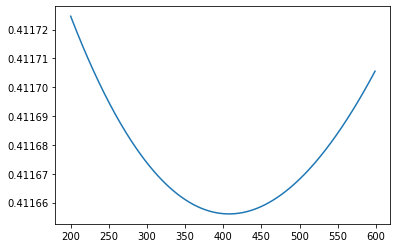

In [52]:
plt.plot(vect,res)

In [53]:
alpha=vect[res.index(min(res))] #optimal parameter
rid = Ridge(alpha).fit(X_train, y_train)
y_pred= rid.predict(X_test)
print('alpha= ',alpha)
print(MCRMSE(y_true, y_pred))

alpha=  408
0.4116560870563001


## Avec pénalisation lasso

In [54]:
res2=[]
vect2=np.arange(0.0001,0.005,0.0001)
for i in vect2:
    las = Lasso(i).fit(X_train, y_train)
    y_pred= las.predict(X_test)
    res2.append(MCRMSE(y_true, y_pred))

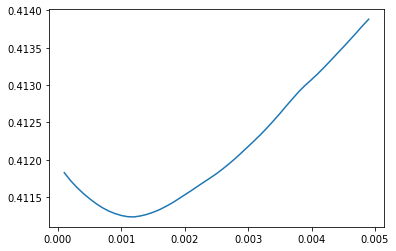

In [55]:
plt.plot(vect2,res2)

In [56]:
alpha2=vect2[res2.index(min(res2))] #optimal parameter
las = Lasso(alpha2).fit(X_train, y_train)
y_pred= las.predict(X_test)
print('alpha= ',alpha2)
print(MCRMSE(y_true, y_pred))

alpha=  0.0012000000000000001
0.4112330036294045
